In [56]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

/var/folders/vr/mg8njp295yn9l8z2g6zgt26c0000gn/T/ipykernel_21699/2867026071.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [59]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538521,72.598899,71.292311,71.545897,135480400
2020-01-03,71.833290,72.594055,71.608685,71.765667,146322800
2020-01-06,72.405685,72.444328,70.703020,70.954195,118387200
2020-01-07,72.065155,72.671348,71.845377,72.415345,108872000
2020-01-08,73.224419,73.526310,71.768094,71.768094,132079200
...,...,...,...,...,...
2025-08-07,219.780563,220.599641,216.334477,218.631873,90224800
2025-08-08,229.090012,230.738135,219.001455,220.579666,113854000


<Axes: xlabel='Date'>

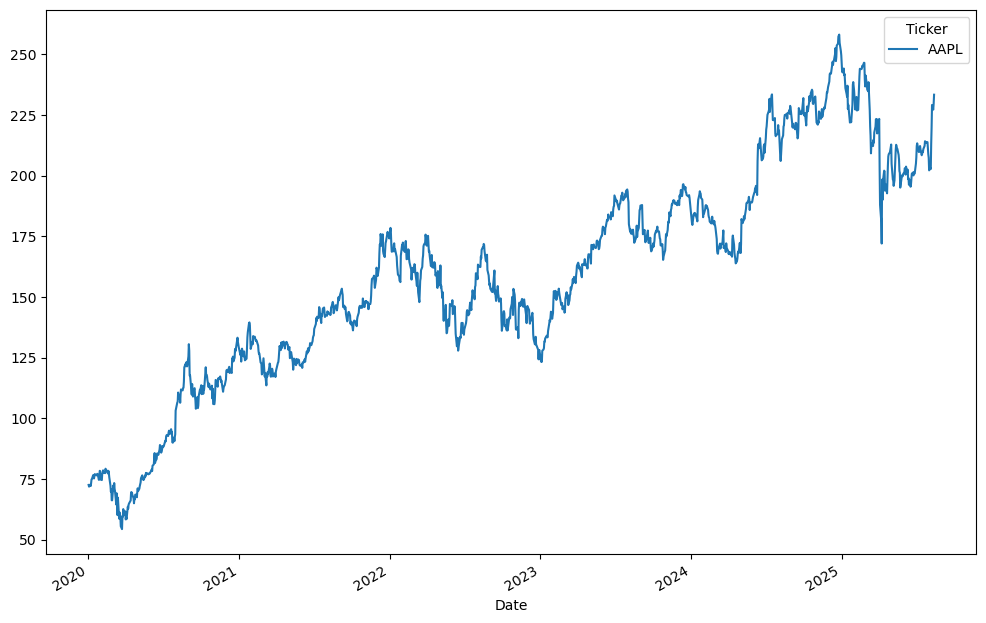

In [60]:
df.Close.plot(figsize = (12,8))

In [61]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [62]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.932516
2020-01-03,-1.948332
2020-01-06,-1.935495
2020-01-07,-1.943132
2020-01-08,-1.917133
...,...
2025-08-07,1.369746
2025-08-08,1.578533
2025-08-11,1.535696


In [63]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [64]:
data

array([[[-1.93251578],
        [-1.9483323 ],
        [-1.93549494],
        ...,
        [-1.82408512],
        [-1.78287604],
        [-1.79552655]],

       [[-1.9483323 ],
        [-1.93549494],
        [-1.94313216],
        ...,
        [-1.78287604],
        [-1.79552655],
        [-1.79509228]],

       [[-1.93549494],
        [-1.94313216],
        [-1.91713285],
        ...,
        [-1.79552655],
        [-1.79509228],
        [-1.82739743]],

       ...,

       [[ 0.9452281 ],
        [ 1.03685221],
        [ 1.09621771],
        ...,
        [ 1.21786063],
        [ 1.36974616],
        [ 1.57853325]],

       [[ 1.03685221],
        [ 1.09621771],
        [ 1.19971499],
        ...,
        [ 1.36974616],
        [ 1.57853325],
        [ 1.53569641]],

       [[ 1.09621771],
        [ 1.19971499],
        [ 1.2245814 ],
        ...,
        [ 1.57853325],
        [ 1.53569641],
        [ 1.59109221]]])

In [65]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [66]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [67]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [68]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [69]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.6523277759552002
25 0.01259737927466631
50 0.005908451043069363
75 0.00532376766204834
100 0.004950577858835459
125 0.004621041473001242
150 0.004318860825151205
175 0.004053439013659954


In [70]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [71]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [72]:
train_rmse

2.7644227

In [73]:
test_rmse

4.7202525

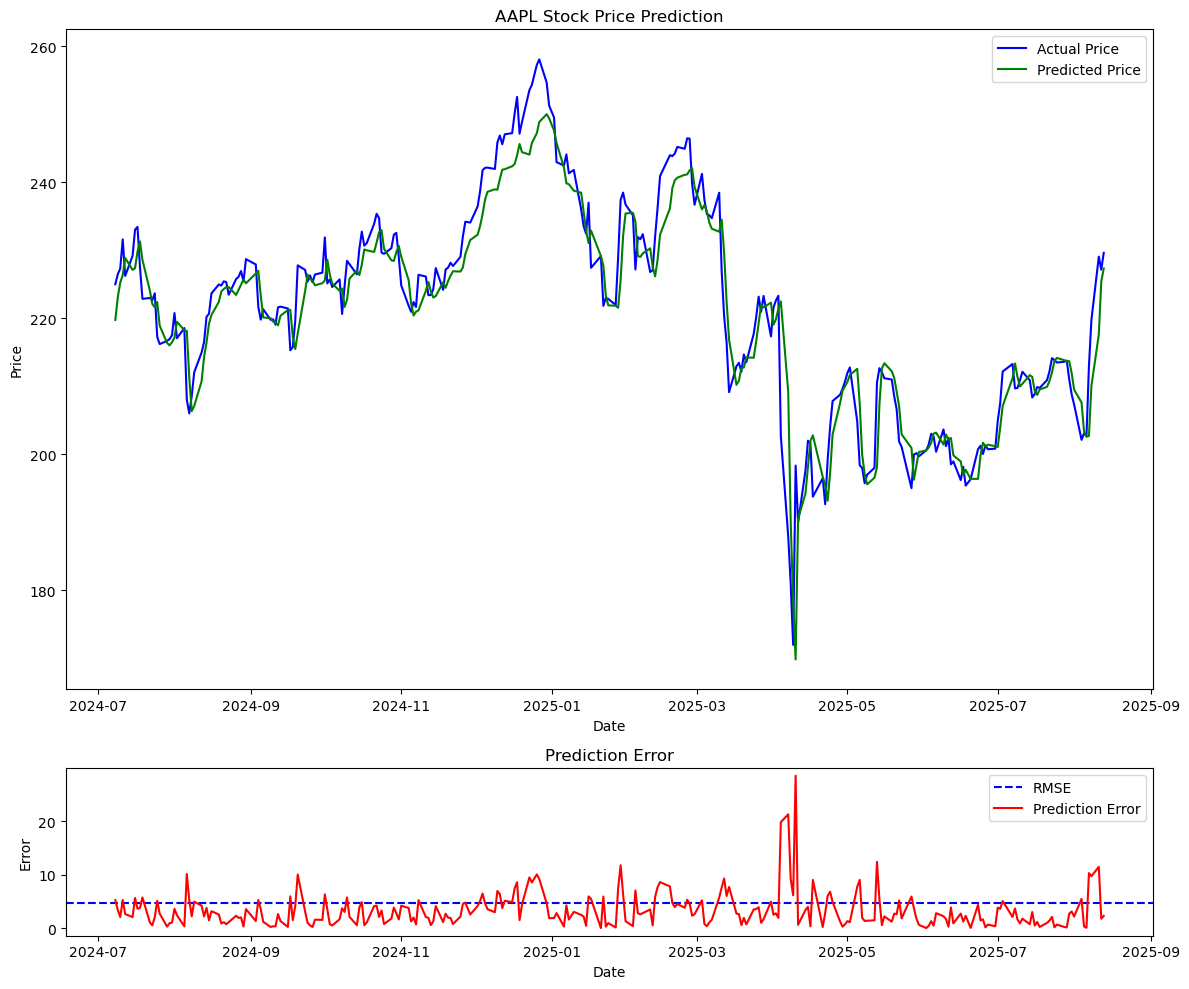

In [74]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'blue', linestyle='--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()

plt.show()